# DeepDream - made simple

### Basic principles of DeepDream

In this notebook we implement a minimal implementation of DeepDream, which is originally described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev. Please  have a look into this document in order to get some initial understanding. 

There is a lot of - more or less complicated - DeepDream implementations available, but in this notebook I wanted to provide an  absolutely minimal implementation in order to present the technical idea behind DeepDream. Despite the minimalism the algorithm still produces nice results. Feel free to expand the implementation in whatever direction you like. There are a lot of possibilities (octaves, etc.) and inspirations you will get on GitHub and other places.

The dreaming works basically as follows: 

* By using a pre-trained network there are lot of optical patterns, which the network has learned and which are memorized in the "subconsciousness" of the network. (We are using a VGG19 network here, which was trained on ImageNet. Because there were lots of animals in the original training classes, there are also lots of weird dog, fish and reptile faces (beneath other stuff) in the "subconsciousness" of the deeper layers of the network. (We are using the 28th layer out of the 43 layers of VGG19 for the "pattern recognition").
* The modification of the image is done by forwarding the image through the network, then "echoing" the loss back to the image and calculating the gradient of the image with respect to the activations of a particular layer (the 28th layer in our case). The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. 

<img src='yellow_fish.JPG'>

The following image shows the DeepDream result of the original image above (taken from https://commons.wikimedia.org/wiki/File:Labidochromis_Caeruleus_Albino_01.JPG).

As you can see, different patterns are "interpreted into" the flora and fauna based on the patterns the VGG19 network has learned before.

<img src='dreamed_fish.JPG'>

### Technical Preconditions
There are the following basic preconditions for running this notebook:
* Pytorch has to be installed (see https://pytorch.org/  for the installation notes)
* The usage of a GPU is highly recommened. (For small images also a CPU "might do it")   

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn

from torchvision import transforms

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
%matplotlib inline

import numpy as np

### Build the neural network

Pytorch offers [pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html), from which we will use the VGG-19 model. If a GPU is available the model is transferred  to the GPU.
The pre-trained VGG-19 model is frozen next because we will only manipulate the resulting target image.

In [3]:
# get the pre-trained VGG-19 model
network = models.vgg19(pretrained=True)
network

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# remove some final layers of the network (layer 28 and the following)
layers = list(network.features.children())
model  = nn.Sequential(*layers[:28])

In [5]:
# freeze all model parameters (because only the resulting target image will be manipulated)
for param in model.parameters():
    param.requires_grad_(False)

In [6]:
# bring model to the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Preprocess the image

Next an image is loaded. Feel free to choose your own image - but note, that not every image fits well for dreaming. In order to process the image, we need the following conversion methods:

* Image (as on the file system) <=> Image (numpy format) <=> Image (Pytorch-specific tensor format)

In [7]:
# decide for an image
input_image = "yellow_fish.jpg"

In [8]:
# open the image
image = Image.open(input_image).convert('RGB') 

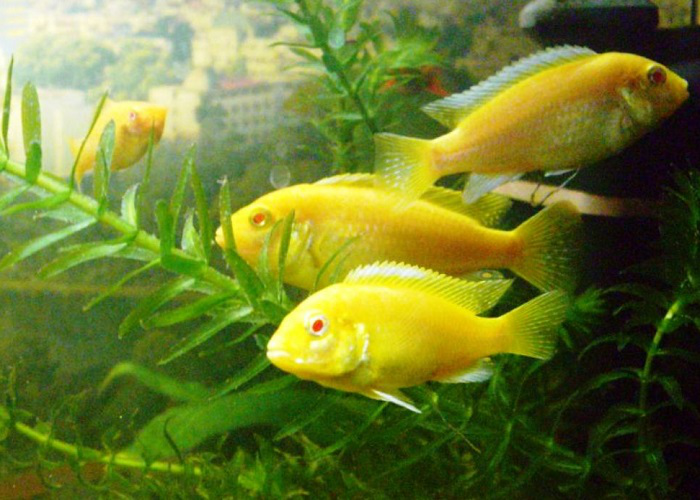

In [9]:
# show the image
display.display(image)

In [10]:
# Normalization factors based on the original training data of the VGG network
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_image(image, max_size=500):
    '''Convert the image file to tensor format and resize it
    
    :param :image    Local file path 
    :param :max_size Maximal pixel size for small side of the image
    :return          Tensor appropriate for network input
    '''   
    
    in_transform = transforms.Compose([transforms.Resize(max_size),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean, std)])
    image = in_transform(image)
    image = image[:3,:,:].unsqueeze(0)
    
    return image

In [11]:
# Bring image to format and make it modifiable (which means: having gradients)
image_tensor = preprocess_image(image)
image_tensor = image_tensor.to(device).requires_grad_(True)

### DeepDream

This is the core algorithm, which does the dreaming by augmenting the image with pre-trained patterns.

In [12]:
def dream(image, model, iterations=300, lr=0.1):
    '''Simple version of DeepDream 
    
    :param :image      Image in tensor format 
    :param :model      Model to be used for dreaming
    :param :iterations Iterations     (which influence the "dreaming intensity")
    :param :lr         Learniang rate (which also influences the "dreaming intensity")
    :return            Dreamed image in numpy format
    '''   
    
    # 1) Send the image through the neural network (downstream)
    # 2) Send the loss back through the neural network (upstream) to the image. 
    #    This kind of backpropagation is "kind of an echo"
    # 3) Add the gradients (= the dreams) to the image
    # 4) Reset the gradients ... and start a new iteration
    for i in range(iterations):
        out         = model(image)                                      
        loss        = out.norm()                                        
        loss.backward()                                         
        image.data += lr * image.grad.data                     
        image.grad.data.zero_()
        
    return image.cpu().data.numpy()

In [13]:
dreamed_image = dream(image_tensor, model, iterations=500)

### Display the DeepDream image

Finally let's have a look at the result.

In [14]:
def deprocess_image(image):
    """Convert the image to an image, which can be plotted 
    This is kind of "reverse operation" to what we did in preprocess_image()
    
    param: image:  Image as produced by the network (in numpy format already)
    return:        Image in numpy format, so it can be plotted
    """
    
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image = image.clip(0, 1)
    
    return image

In [16]:
# bring the image in a displayable format
display_image = deprocess_image(dreamed_image)

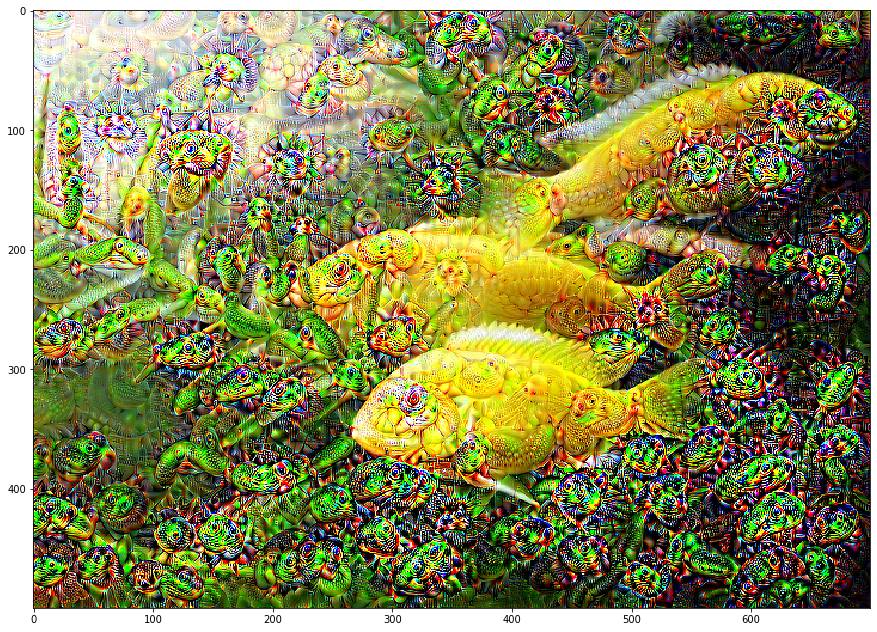

In [17]:
# display the dreamed image
plt.figure(figsize=(15, 15))
plt.imshow(display_image)